#Setup

In [109]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
image_dir = '/content/drive/MyDrive/Dataset Dr.Fruithy/Apple'

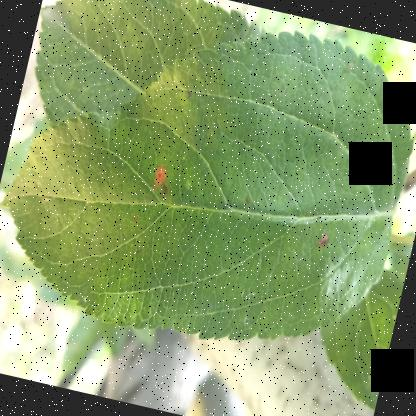

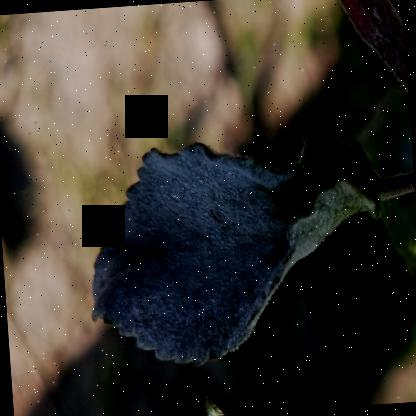

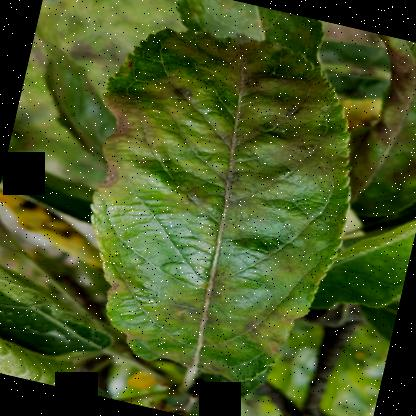

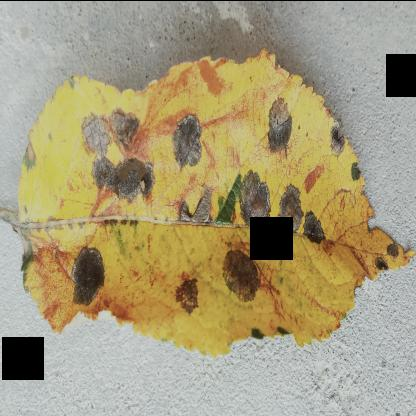

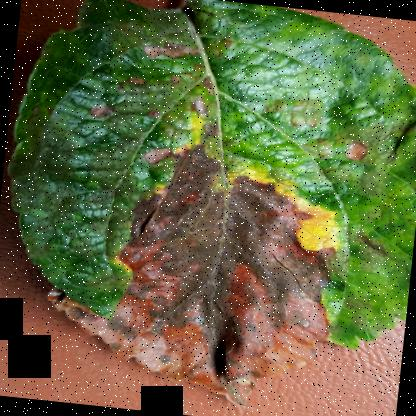

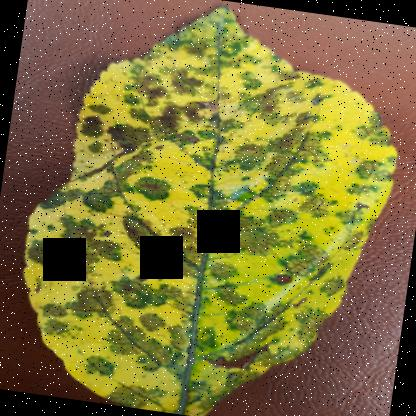

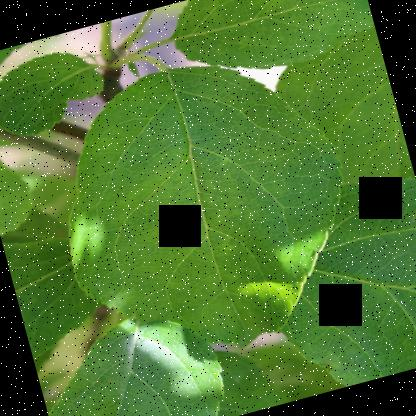

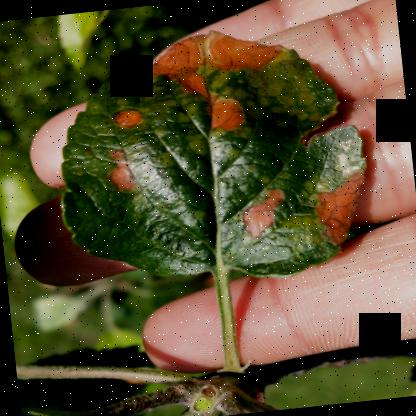

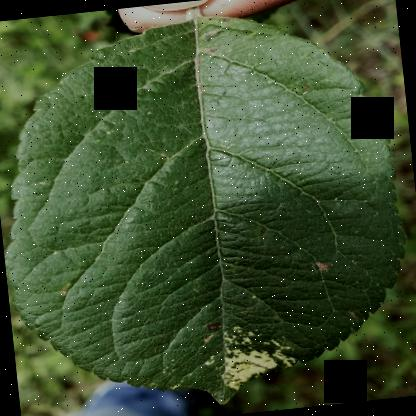

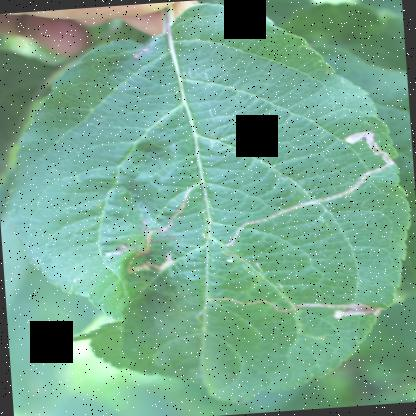

In [112]:
from IPython.display import display, Image, HTML

# melist semua image direktori
folders = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]

# Menampilkan 1 sampel dari setiap folder disease mangga
for folder in folders:
    folder_path = os.path.join(image_dir, folder)
    images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if images:
        sample_image = images[0]
        image_path = os.path.join(folder_path, sample_image)
        display(HTML(f'<h3>{folder}</h3>'))
        display(Image(filename=image_path, width=200))

In [113]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (240, 320),
    batch_size = 32)

Found 5851 files belonging to 10 classes.


In [114]:
dataset.class_names

['alternaria',
 'demaged',
 'healthy',
 'insect',
 'mlb',
 'mossaic',
 'multiple',
 'necrosis',
 'powdery-mildew',
 'scab']

In [115]:
def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
    # menegatur
    dataset_size = len(ds)

    # Calculate split sizes
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle dataset if required
    if shuffle:
        ds = ds.shuffle(dataset_size)

    # Split dataset
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset

In [116]:
train_ds, val_ds, test_ds = split_dataset(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Data Augmentation

In [117]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(240,320),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [118]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    tf.keras.layers.RandomBrightness(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Build Model

In [119]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1

In [120]:
from tensorflow.keras.optimizers import Adam
resize_and_rescale,
data_augmentation,

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(240, 320, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  # Flatten layer
  tf.keras.layers.Flatten(),

  # Add fully connected layers with dropout and regularization
  tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [121]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [122]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 240, 320, 64)      1792      
                                                                 
 batch_normalization_3 (Bat  (None, 240, 320, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 120, 160, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 160, 128)     73856     
                                                                 
 batch_normalization_4 (Bat  (None, 120, 160, 128)     512       
 chNormalization)                                                
                                                      

# Model Train

In [123]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20
146/146 [==============================] - 55s 294ms/step - loss: 4.0119 - accuracy: 0.3593 - val_loss: 2.2734 - val_accuracy: 0.5271
Epoch 2/20
146/146 [==============================] - 33s 224ms/step - loss: 2.2945 - accuracy: 0.4860 - val_loss: 2.0706 - val_accuracy: 0.5744
Epoch 3/20
146/146 [==============================] - 33s 226ms/step - loss: 2.0574 - accuracy: 0.5455 - val_loss: 1.8031 - val_accuracy: 0.6077
Epoch 4/20
146/146 [==============================] - 33s 224ms/step - loss: 1.8268 - accuracy: 0.5935 - val_loss: 1.6579 - val_accuracy: 0.6287
Epoch 5/20
146/146 [==============================] - 33s 224ms/step - loss: 1.6913 - accuracy: 0.6372 - val_loss: 1.6266 - val_accuracy: 0.6550
Epoch 6/20
146/146 [==============================] - 33s 225ms/step - loss: 1.5301 - accuracy: 0.6685 - val_loss: 1.3722 - val_accuracy: 0.7320
Epoch 7/20
146/146 [==============================] - 33s 224ms/step - loss: 1.4117 - accuracy: 0.7045 - val_loss: 1.3147 - val_ac

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

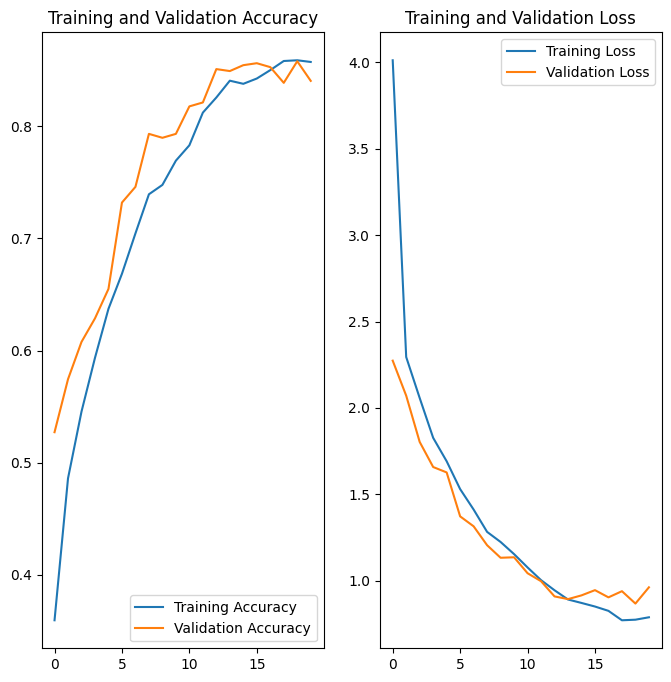

In [125]:
EPOCHS = 20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model Prediction

In [126]:
class_names = dataset.class_names
class_names

['alternaria',
 'demaged',
 'healthy',
 'insect',
 'mlb',
 'mossaic',
 'multiple',
 'necrosis',
 'powdery-mildew',
 'scab']

first image to predict
actual label: multiple
1/1 [==============================] - 0s 185ms/step
predicted label: multiple


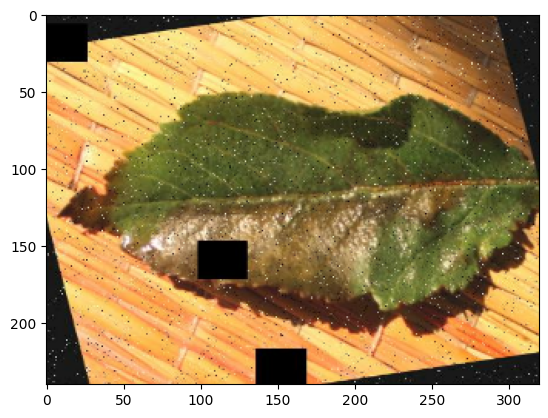

In [127]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [128]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


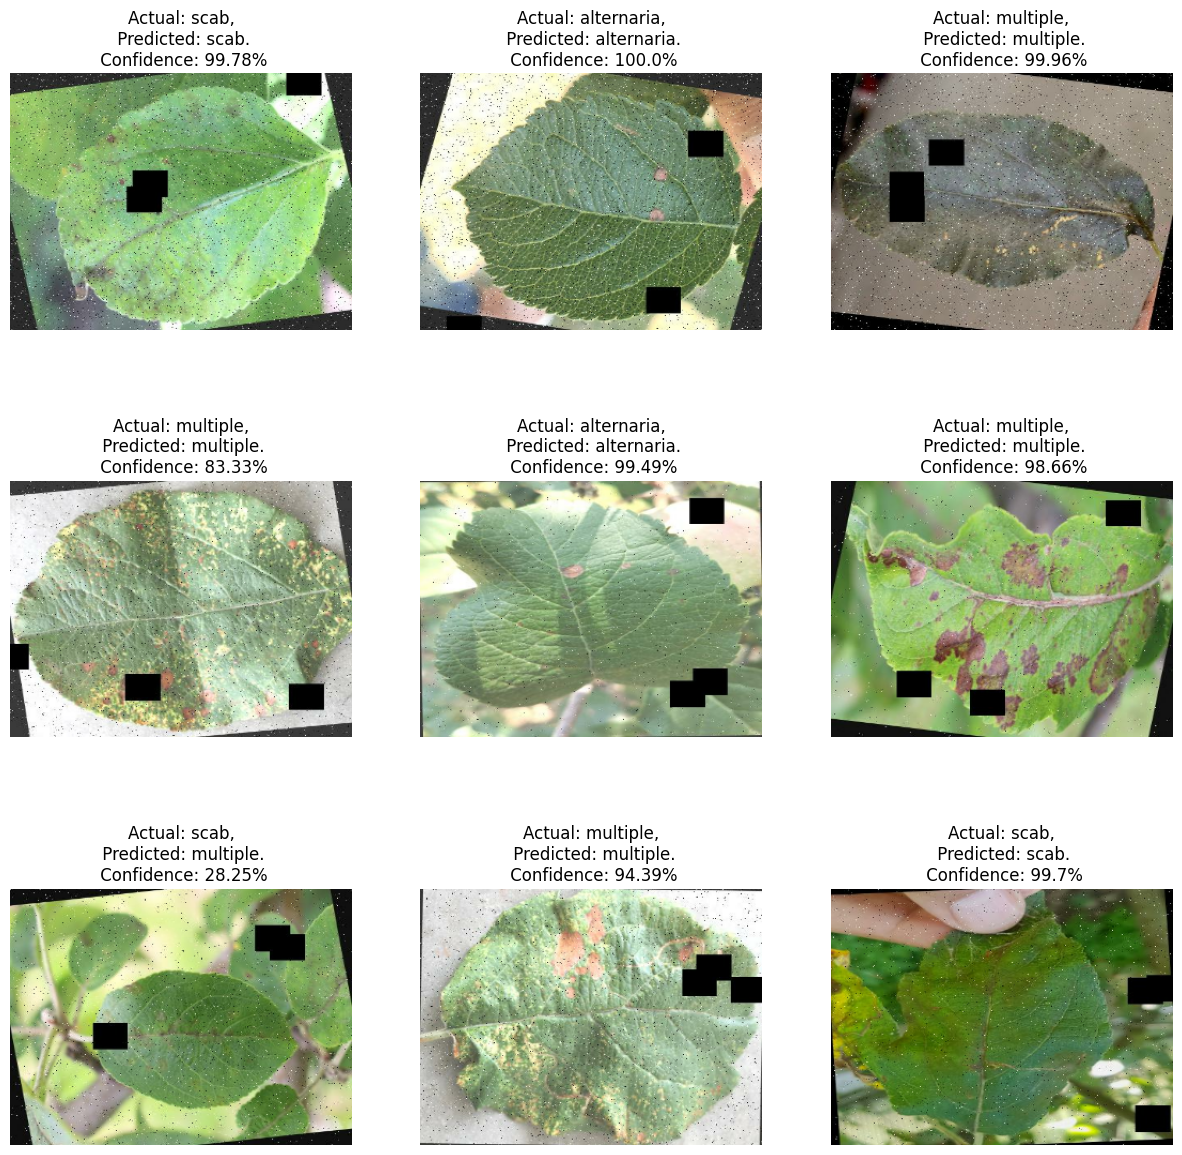

In [129]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Export Model

In [130]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format.
export_dir = 'saved_model/1'

tf.saved_model.save(model,export_dir=export_dir)

In [131]:
# Select mode of optimization
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [132]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert();

In [133]:
import pathlib

In [134]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

79066624

In [135]:
# pip install flatbuffers

In [136]:
import tensorflow as tf
import flatbuffers

# Load the labels from the file
with open("labels_apple.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Create a TFLite model converter
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/1")

# Convert the model to TFLite format
tflite_model = converter.convert()

# Create a metadata buffer
metadata_buffer = bytearray()

# Create a flatbuffers builder
builder = flatbuffers.Builder(1024)

# Create a string for the metadata name
name = builder.CreateString("labels")

# Create a string for the metadata description
description = builder.CreateString("Labels for the apple disease detection model")

# Create a vector of strings for the labels
labels_offsets = [builder.CreateString(label) for label in labels]
labels_vector = builder.StartVector(4, len(labels), 4)
for offset in reversed(labels_offsets):
    builder.PrependUOffsetTRelative(offset)
labels_vector = builder.EndVector(len(labels))

# Start the metadata object with 3 fields (name, description, labels)
builder.StartObject(3)

# Add the fields to the metadata object
builder.PrependUOffsetTRelativeSlot(0, name, 0)
builder.PrependUOffsetTRelativeSlot(1, description, 0)
builder.PrependUOffsetTRelativeSlot(2, labels_vector, 0)

# Finish the metadata object
metadata_obj = builder.EndObject()

# Add the metadata object to the metadata buffer
builder.PrependUint32(metadata_obj)
builder.PrependUint32(len(metadata_buffer))
metadata_buffer.extend(builder.Bytes)

# Add the metadata buffer to the TFLite model
tflite_model = tflite_model[:4] + len(metadata_buffer).to_bytes(4, byteorder='little') + metadata_buffer + tflite_model[8:]

# Save the TFLite model to a file
import pathlib
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

<ipython-input-136-b053c3cc9ee9>:31: DeprecationWarning: numElems is deprecated.
  labels_vector = builder.EndVector(len(labels))


316204904

In [137]:
# from google.colab import files

# # Download the model file
# files.download('model.tflite')